In [2]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from astropy.stats import LombScargle
from astropy.table import Table
from scipy.signal import savgol_filter
import fitsio

import halophot
from halophot.halo_tools import halo_tpf
import lightkurve 
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve

print(halophot.__version__)

0.6.6.3


In [3]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=22              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

Populating the interactive namespace from numpy and matplotlib


In [4]:
mv /Users/benjaminpope/code/halophot/data/te* ../data/

mv: rename /Users/benjaminpope/code/halophot/data/te* to ../data/te*: No such file or directory


In [5]:
ls ../data/

all_targets_S003_v1.txt
astrocut_26.0170142608_-15.9374795978_50x100px.zip
tess-s0003-1-2_26.0170142608_-15.9374795978_20x20_astrocut.fits
tess-s0003-1-2_26.0170142608_-15.9374795978_25x35_astrocut.fits
tess-s0003-1-2_26.0170142608_-15.9374795978_50x100_astrocut.fits
tess-s0003-1-2_26.0170142608_-15.9374795978_50x20_astrocut.fits
tess2018263035959-s0003-0000000419015728-0123-s_lc.fits
tess2018263035959-s0003-0000000419015728-0123-s_tp.fits
tess2018263172941-s0003-1-2-0123-s_ffic.fits
tess2018277172940-s0003-1-2-0123-s_ffir.fits
tess2018277175940-s0003-1-2-0123-s_ffic.fits


In [6]:
tic = 24924016 # brightest on 1-2 - zet Cet

In [11]:
fname_lc = lightkurve.search_lightcurvefile(tic)

lc_pipeline = fname_lc.download()
pdc = lc_pipeline.get_lightcurve('PDCSAP_FLUX')
fname_tpf = lightkurve.search_targetpixelfile(tic)
tpf = fname_tpf.download()
background = tpf.get_bkg_lightcurve()

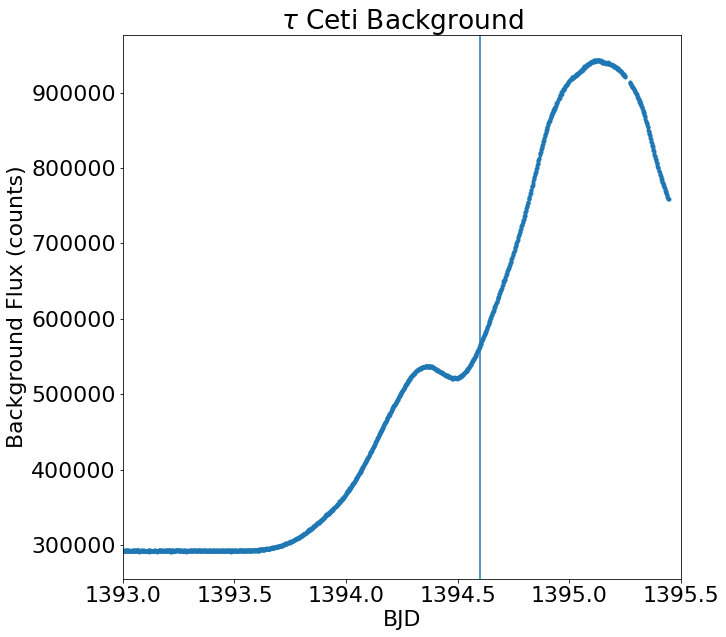

In [8]:
plt.plot(background.time,background.flux,'.')
plt.axvline(1394.6)
plt.xlim(1393,1395.5)
plt.xlabel('BJD')
plt.ylabel('Background Flux (counts)')
plt.title(r'$\tau$ Ceti Background')
plt.savefig('zeta_ceti_background.png')

In [12]:
np.nanmax(tpf.flux)

107930.05

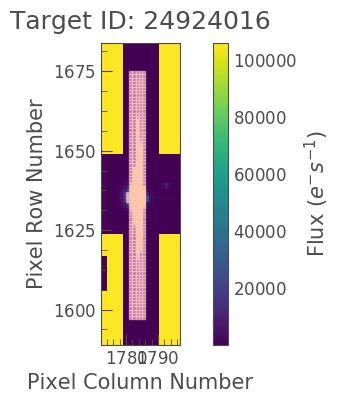

In [13]:
tpf.plot(frame=1,aperture_mask=tpf.pipeline_mask)

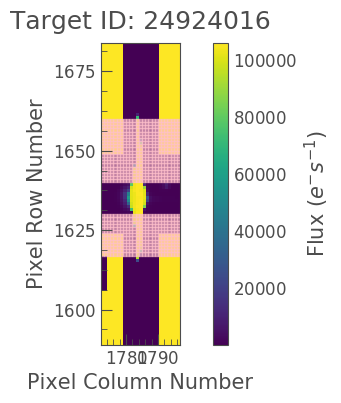

In [37]:
ymin = 30
xmin, xmax = 41,51
ymin, ymax = 0,50
newmask = np.ones((tpf.flux.shape[1],tpf.flux.shape[2]),dtype='bool')
xx, yy = np.meshgrid(np.arange(newmask.shape[0]),np.arange(newmask.shape[1]))

xc, yc = np.mean([xmin,xmax]), np.mean([ymin,ymax])
rr = np.sqrt((xx-xc)**2 + (yy-yc)**2)

rmax = 10
rmin = 3
# newmask[(rr>rmax).T] = False
# newmask[(rr<rmin).T] = False

newmask[(xx<xmax).T] = False

newmask[(xx<xmin).T] = True
newmask[(yy<ymin).T] = True
newmask[(yy>ymax).T] = True
 
newmask[(xx>70).T] = False
newmask[(xx<28).T] = False

tpf.plot(frame=1,aperture_mask=newmask)
# plt.savefig('tauCeti_mask.png',bbox_inches='tight')

In [38]:
tpf.interact(aperture_mask=newmask) # move the slider around in the vicinity of the transit and get stretch ~ (1.72-2.92) - flux is redistributed

### Now run halo

In [39]:
tpf.__class__ = halo_tpf

In [40]:
%%time
weightmap, corr_lc = tpf.halo(order=2,mask=newmask,minflux=-100,thresh=0.5);

Taking cadences from beginning to end
74 saturated pixels
Censored TPF
Subsampling by a factor of 1
Calculating weights
Using Analytic Derivatives
Calculated weights!
CPU times: user 26.5 s, sys: 5.29 s, total: 31.8 s
Wall time: 10.3 s


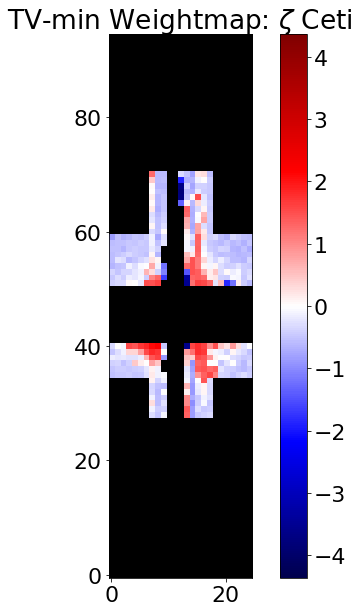

In [41]:
norm = np.size(weightmap['weightmap'])

cmap = mpl.cm.seismic
cmap.set_bad('k',1.)
wmap = weightmap['weightmap'].T*norm
im = np.log10(wmap)
plt.imshow(im,cmap=cmap, vmin=-2*np.nanmax(im),vmax=2*np.nanmax(im),
    interpolation='None',origin='lower')
plt.colorbar()
plt.title(r'TV-min Weightmap: $\zeta$ Ceti')
plt.savefig('zeta_ceti_weights.png',bbox_inches='tight')

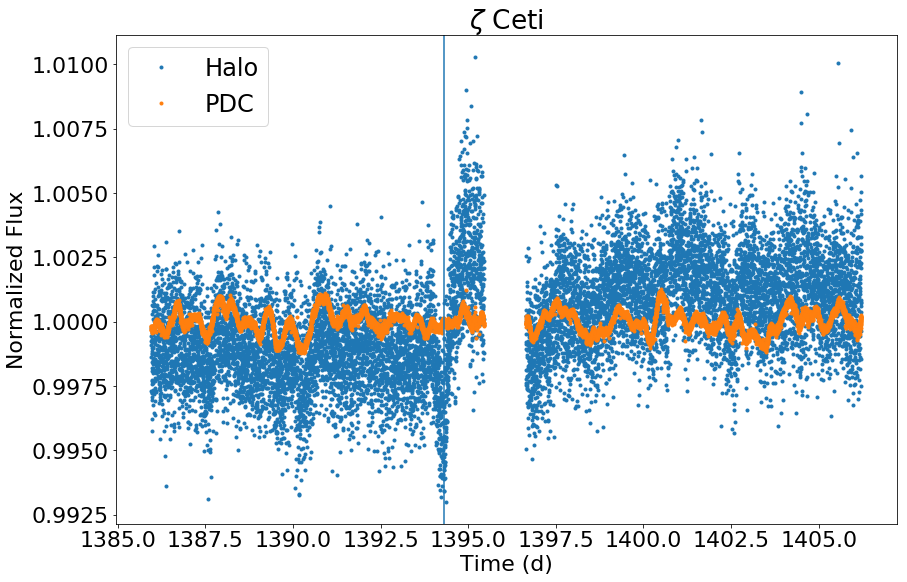

In [43]:
fig = plt.figure(figsize=(14,9))

plt.plot(corr_lc.time,corr_lc.flux/np.nanmedian(corr_lc.flux),'.',label='Halo')
plt.plot(pdc.time,pdc.flux/np.nanmedian(pdc.flux),'.',label='PDC')

# plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.',label='Sum')
# plt.xlim(1327,1339)
# plt.ylim(1.004,1.01)
plt.legend(fontsize=24)
plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title(r'$\zeta$ Ceti')
# plt.savefig('zeta-Ceti-test.png')
# plt.xlim(1392.5,1395.0)
plt.axvline(1394.3)
# plt.ylim(0.99,1.01)

### Can we do the CBVs?

In [48]:
print(tpf.camera,'-',tpf.ccd)

1 - 2


In [49]:
cbv_fname = '/Users/benjaminpope/code/chemex/data/cbvs/tess/tess2018263035959-s0003-1-2-0123-s_cbv.fits'

In [61]:
cbvs = fitsio.FITS(cbv_fname)[1]

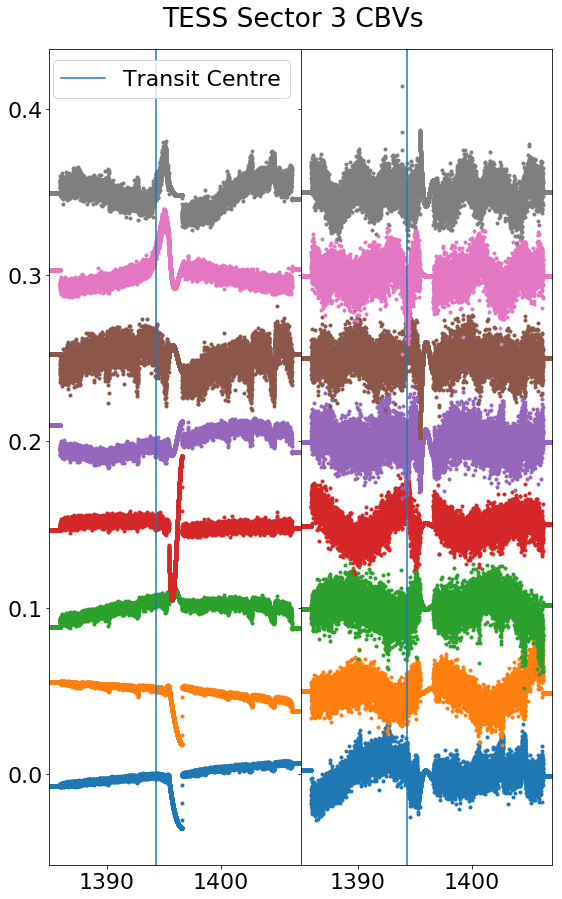

In [104]:
cbv_fname = '/Users/benjaminpope/code/chemex/data/cbvs/tess/tess2018263035959-s0003-1-2-0123-s_cbv.fits'
cbvs = fitsio.FITS(cbv_fname)[1]
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(9.0,15.0),sharey=True)
cbvtime = cbvs['TIME'][:]
for j in range(8):
    vector = cbvs['VECTOR_%d'% (j+1)][:]
    ax1.plot(cbvtime,vector+0.05*j,'.')
for j in range(8):
    vector = cbvs['VECTOR_%d'% (j+9)][:]
    ax2.plot(cbvtime,vector+0.05*j,'.')
transit = ax1.axvline(1394.3,label='Transit Centre')
fig.subplots_adjust(wspace=0)
ax2.axvline(1394.3)
ax1.set_xlim(1385,1407);
ax2.set_xlim(1385,1407);
ax1.legend([transit,],['Transit Centre'],loc=1)
fig.suptitle('TESS Sector 3 CBVs',y=0.92)
plt.savefig('s3_cbvs.png',bbox_inches='tight')

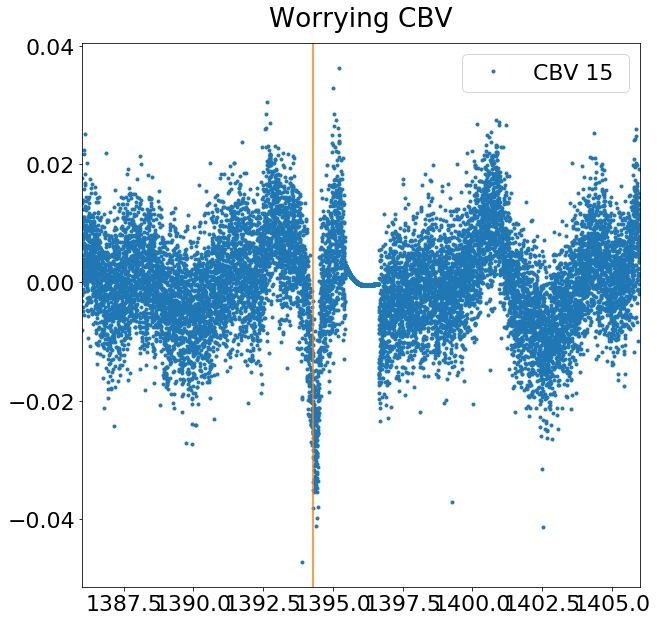

In [120]:
cbv_fname = '/Users/benjaminpope/code/chemex/data/cbvs/tess/tess2018263035959-s0003-1-2-0123-s_cbv.fits'
cbvs = fitsio.FITS(cbv_fname)[1]
vector = cbvs['VECTOR_15'][:]
plt.plot(cbvtime,vector,'.',label='CBV 15 ' )
plt.axvline(1394.3,color=colours[1])
plt.xlim(1386,1406);
plt.legend()
plt.title('Worrying CBV',y=1.02)
plt.savefig('worrying.png',bbox_inches='tight')
# for j in range(8):
#     vector = cbvs['VECTOR_%d'% (j+9)][:]
#     ax2.plot(cbvtime,vector+0.05*j,'.')
# transit = ax1.axvline(1394.3,label='Transit Centre')
# fig.subplots_adjust(wspace=0)
# ax2.axvline(1394.3)
# ax1.set_xlim(1385,1407);
# ax2.set_xlim(1385,1407);
# ax1.legend([transit,],['Transit Centre'],loc=1)
# fig.suptitle('TESS Sector 3 CBVs',y=0.92)
# plt.savefig('s3_cbvs.png',bbox_inches='tight')

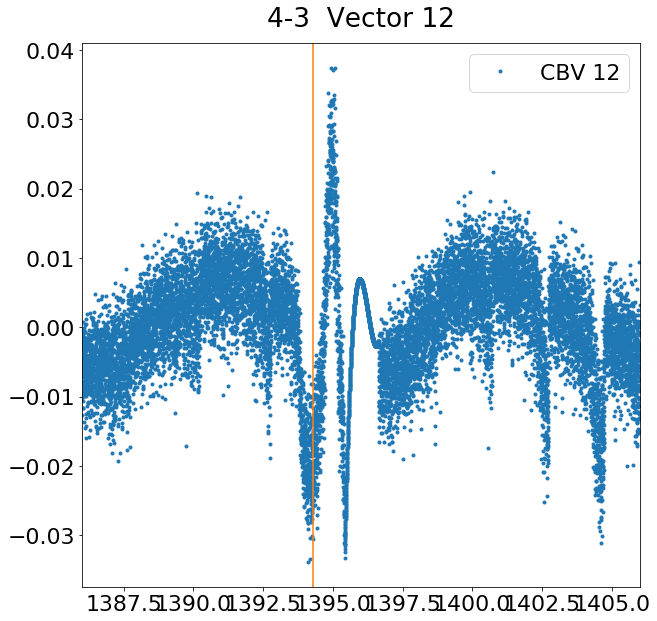

In [142]:
cbv_43_fname = '/Users/benjaminpope/code/chemex/data/cbvs/tess/tess2018263035959-s0003-4-3-0123-s_cbv.fits'
cbvs = fitsio.FITS(cbv_43_fname)[1]

j = 12
vector = cbvs['VECTOR_%s' % j][:]
plt.plot(cbvtime,vector,'.',label='CBV %s' % j)
plt.axvline(1394.3,color=colours[1])
plt.xlim(1386,1406);
plt.legend()
plt.title('4-3  Vector %s' % j,y=1.02)
plt.savefig('4-3_vector_%s.png' % j,bbox_inches='tight')
# for j in range(8):
#     vector = cbvs['VECTOR_%d'% (j+9)][:]
#     ax2.plot(cbvtime,vector+0.05*j,'.')
# transit = ax1.axvline(1394.3,label='Transit Centre')
# fig.subplots_adjust(wspace=0)
# ax2.axvline(1394.3)
# ax1.set_xlim(1385,1407);
# ax2.set_xlim(1385,1407);
# ax1.legend([transit,],['Transit Centre'],loc=1)
# fig.suptitle('TESS Sector 3 CBVs',y=0.92)
# plt.savefig('s3_cbvs.png',bbox_inches='tight')

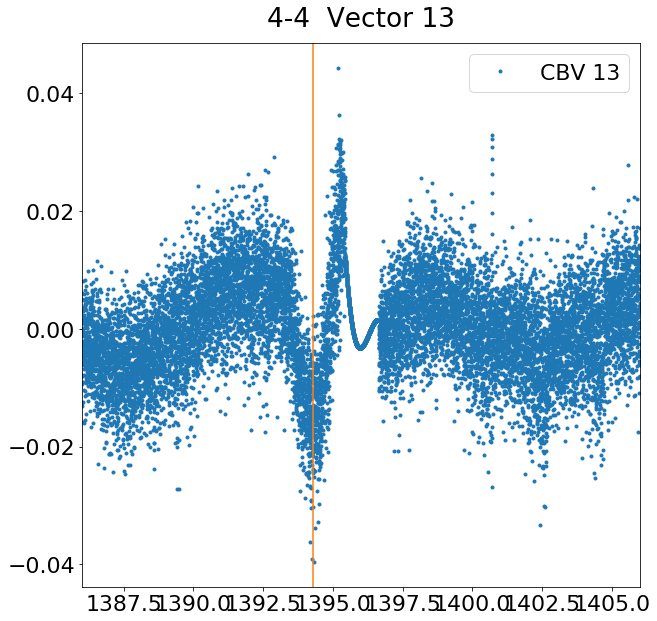

In [143]:
cbv_44_fname = '/Users/benjaminpope/code/chemex/data/cbvs/tess/tess2018263035959-s0003-4-4-0123-s_cbv.fits'
cbvs = fitsio.FITS(cbv_44_fname)[1]

j = 13
vector = cbvs['VECTOR_%s' % j][:]
plt.plot(cbvtime,vector,'.',label='CBV %s' % j)
plt.axvline(1394.3,color=colours[1])
plt.xlim(1386,1406);
plt.legend()
plt.title('4-4  Vector %s' % j,y=1.02)
plt.savefig('4-4_vector_%s.png' % j,bbox_inches='tight')
# for j in range(8):
#     vector = cbvs['VECTOR_%d'% (j+9)][:]
#     ax2.plot(cbvtime,vector+0.05*j,'.')
# transit = ax1.axvline(1394.3,label='Transit Centre')
# fig.subplots_adjust(wspace=0)
# ax2.axvline(1394.3)
# ax1.set_xlim(1385,1407);
# ax2.set_xlim(1385,1407);
# ax1.legend([transit,],['Transit Centre'],loc=1)
# fig.suptitle('TESS Sector 3 CBVs',y=0.92)
# plt.savefig('s3_cbvs.png',bbox_inches='tight')

In [145]:
from oxksc.cbvc import cbv

def match_cadences(cbvcads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in cbvcads])
    return np.where(indices==1)[0]

def correct_quarter(lc,cbv_fname,nB=4):
    cbvfile = fitsio.FITS(cbv_fname)

    cads = match_cadences(cbvfile[1]['CADENCENO'][:],lc.cadenceno)
    basis = np.zeros((lc.flux.shape[0],16))

    for j in range(16):
        try:
            basis[:,j] = cbvfile[1]['VECTOR_%d'% (j+1)][cads]
        except:
            print('Missing CBV',j)

    corrected_flux, weights = cbv.fixed_nb(lc.flux, basis,nB=nB, doPlot = False)

    return corrected_flux


In [146]:
corrflux = correct_quarter(corr_lc,cbv_fname,nB=8)

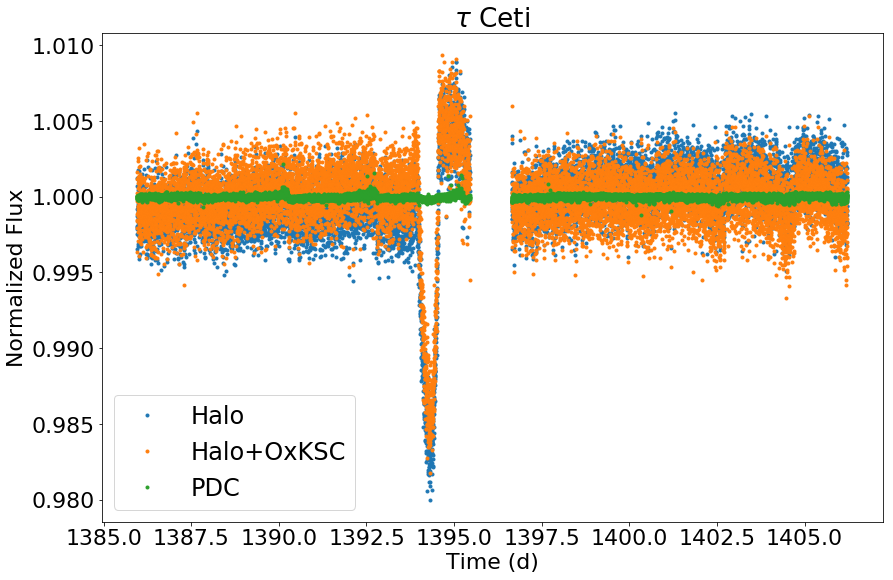

In [148]:
fig = plt.figure(figsize=(14,9))

plt.plot(corr_lc.time,corr_lc.flux/np.nanmedian(corr_lc.flux),'.',label='Halo')
plt.plot(corr_lc.time,corrflux/np.nanmedian(corrflux),'.',label='Halo+OxKSC')
plt.plot(pdc.time,pdc.flux/np.nanmedian(pdc.flux),'.',label='PDC')

# plt.plot(lc.time, lc.flux/np.nanmedian(lc.flux),'.',label='Sum')
# plt.xlim(1327,1339)
# plt.ylim(1.004,1.01)
plt.legend(fontsize=24)
plt.ylabel('Normalized Flux')
plt.xlabel('Time (d)')
plt.title(r'$\tau$ Ceti')
plt.savefig('tau-Ceti-test.png')

In [58]:
data= Table({'cadence':corr_lc.cadenceno,'time':corr_lc.time,'oxksc':corrflux/np.nanmedian(corrflux),'halo':corr_lc.flux/np.nanmedian(corr_lc.flux)})
data.write('tauCeti_halo.csv')

### More processing

In [149]:
ff = fitsio.FITS(fname_lc)

In [153]:
tt, x, y = ff[1]['TIME'][:], ff[1]['POS_CORR1'][:], ff[1]['POS_CORR2'][:]

Text(0.5, 1.0, 'Position of $\\tau$ Ceti')

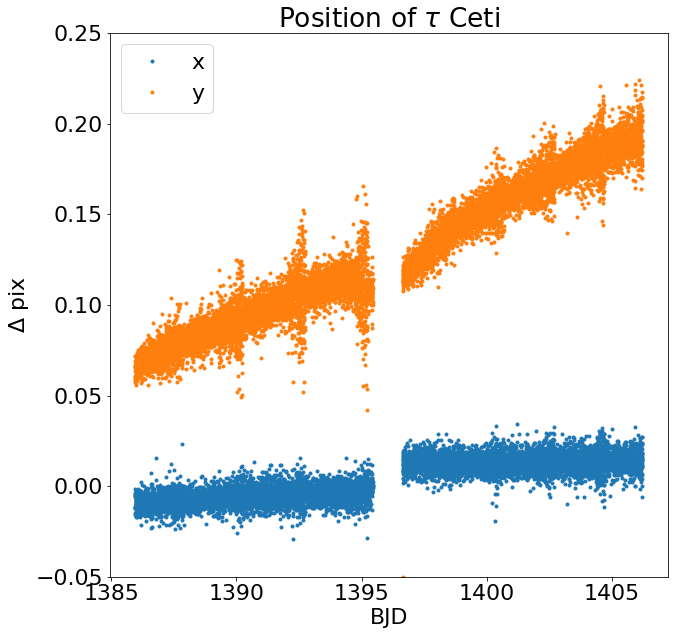

In [161]:
plt.plot(tt,x,'.',label='x')
plt.plot(tt,y+0.1,'.',label='y')
plt.ylim(-0.05,0.25)
plt.legend()
plt.xlabel('BJD')
plt.ylabel(r'$\Delta$ pix')
plt.title(r'Position of $\tau$ Ceti')